In [1]:
import os
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from pointnet2_ops.pointnet2_modules import PointnetSAModuleMSG
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'pointnet2_ops'

In [24]:
sydney_datast = r"C:/UT/1508Project/sydney-urban-objects-dataset/sydney-urban-objects-dataset"
objects_path = os.path.join(sydney_datast, "objects")

print(os.listdir(objects_path))

['4wd.0.2299.bin', '4wd.0.2299.bin.meta', '4wd.0.2299.csv', '4wd.1.2446.bin', '4wd.1.2446.bin.meta', '4wd.1.2446.csv', '4wd.10.17589.bin', '4wd.10.17589.bin.meta', '4wd.10.17589.csv', '4wd.11.6994.bin', '4wd.11.6994.bin.meta', '4wd.11.6994.csv', '4wd.12.3582.bin', '4wd.12.3582.bin.meta', '4wd.12.3582.csv', '4wd.13.270.bin', '4wd.13.270.bin.meta', '4wd.13.270.csv', '4wd.14.5229.bin', '4wd.14.5229.bin.meta', '4wd.14.5229.csv', '4wd.15.5563.bin', '4wd.15.5563.bin.meta', '4wd.15.5563.csv', '4wd.16.6123.bin', '4wd.16.6123.bin.meta', '4wd.16.6123.csv', '4wd.17.6783.bin', '4wd.17.6783.bin.meta', '4wd.17.6783.csv', '4wd.18.7288.bin', '4wd.18.7288.bin.meta', '4wd.18.7288.csv', '4wd.19.10974.bin', '4wd.19.10974.bin.meta', '4wd.19.10974.csv', '4wd.2.3582.bin', '4wd.2.3582.bin.meta', '4wd.2.3582.csv', '4wd.20.12346.bin', '4wd.20.12346.bin.meta', '4wd.20.12346.csv', '4wd.3.4043.bin', '4wd.3.4043.bin.meta', '4wd.3.4043.csv', '4wd.4.17038.bin', '4wd.4.17038.bin.meta', '4wd.4.17038.csv', '4wd.5.17038.

In [4]:
labels_dict = {
    '4wd': 0,
    'bench': 1,
    'bicycle': 2,
    'biker': 3,
    'building': 4,
    'bus': 5,
    'car': 6,
    'cyclist': 7,
    'excavator': 8,
    'pedestrian': 9,
    'pillar': 10,
    'pole': 11,
    'post': 12,
    'scooter': 13,
    'ticket_machine': 14,
    'traffic_lights': 15,
    'traffic_sign': 16,
    'trailer': 17,
    'trash': 18,
    'tree': 19,
    'truck': 20,
    'trunk': 21,
    'umbrella': 22,
    'ute': 23,
    'van': 24,
    'vegetation': 25
}

num_classes = len(labels_dict)

In [5]:
def read_bin(file_name):
    names   = ['t','intensity','id','x','y','z','azimuth','range','pid']
    formats = ['int64','uint8','uint8',
               'float32','float32','float32',
               'float32','float32','int32']

    binType = np.dtype(dict(names=names, formats=formats))
    data = np.fromfile(file_name, binType)

    # 3D points, one per row:
    P = np.vstack((data['x'], data['y'], data['z'])).T
    return P


In [6]:
def sub_sample(pcs, labels, k):
    res1 = np.concatenate((pcs, np.reshape(labels, (labels.shape[0], 1))), axis=1)
    chosen = random.choices(res1, k=k)  
    chosen = np.asarray(chosen)
    
    pcs_out = chosen[:, :-1]
    labels_out = chosen[:, -1]
    return pcs_out, labels_out

In [16]:
class SydneyUrban(Dataset):
    def __init__(self, file_paths, labels, sample_size=1024, transform=False):
        self.files = file_paths
        self.labels = labels
        self.sample_size = sample_size
        self.transform = transform

    def __len__(self):
        return len(self.files)
    
    def _normalize(self, points):
        centroid = np.mean(points, axis=0)
        points -= centroid
        max_distance = np.max(np.sqrt(np.sum(abs(points) ** 2, axis=1)))
        points /= max_distance
        return points

    def __getitem__(self, idx):
        pts_path = self.files[idx]
        label = self.labels[idx]

        pts = read_bin(pts_path)  

        label_array = np.full((len(pts),), label)  

        pts, label_array = sub_sample(pts, label_array, self.sample_size)
        pts = self._normalize(pts)

        return {
            "points": np.array(pts, dtype="float32"),
            "label": np.array(label, dtype="int32")
        }

In [17]:
all_files = [
    os.path.join(objects_path,f)
    for f in os.listdir(objects_path)
    if f.endswith('.bin') and not f.endswith('.bin.meta')
    ]

all_labels = []
for f in all_files:
    file_name = os.path.basename(f)
    label_str = file_name.split('.')[0]
    num_label = labels_dict[label_str]
    all_labels.append(num_label)

In [18]:
len(all_files), len(all_labels)

(631, 631)

In [19]:
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42) 

In [20]:
train_dataset = SydneyUrban(train_files, train_labels, sample_size=1024)
test_dataset = SydneyUrban(test_files, test_labels, sample_size=1024)

In [21]:
len(train_dataset), len(test_dataset)

(504, 127)

#### Visualize the dataset

In [22]:
reverse_labels = {v: k for k, v in labels_dict.items()}

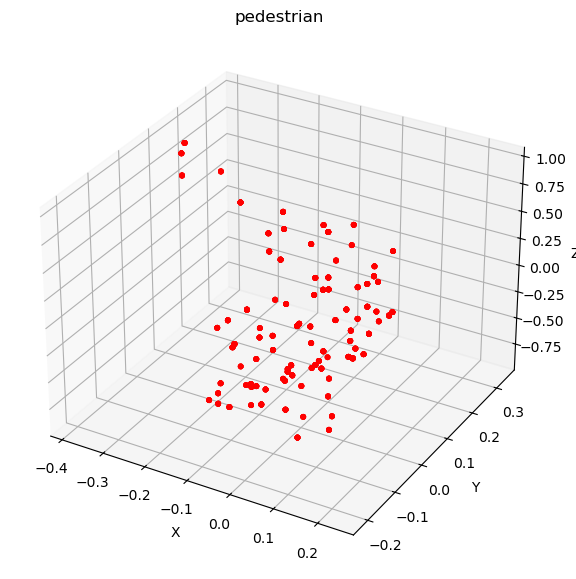

Class: pedestrian


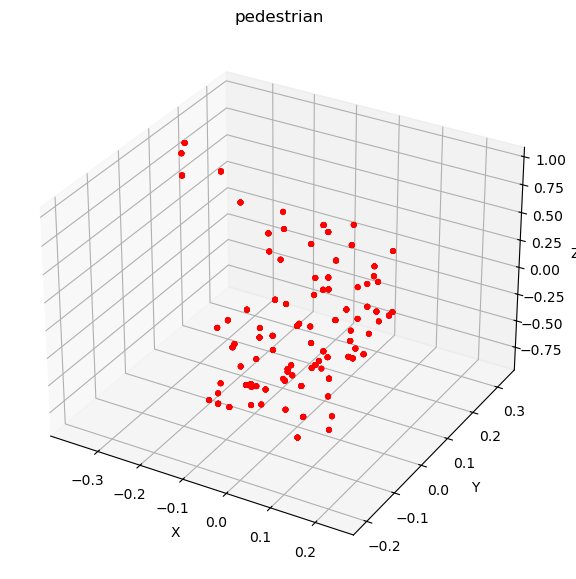

Class: pedestrian


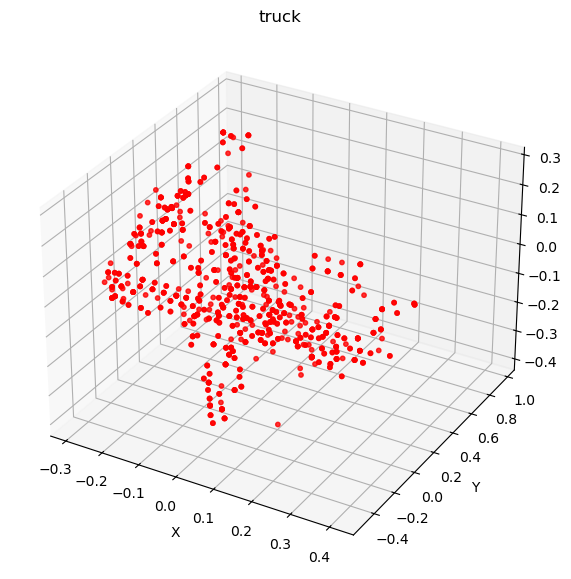

Class: truck


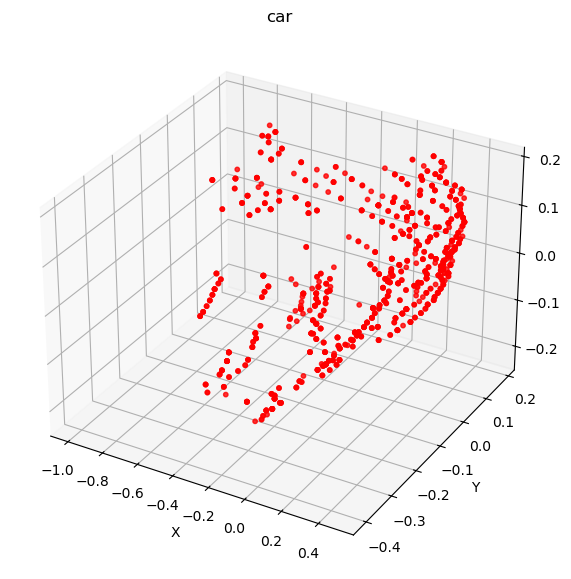

Class: car


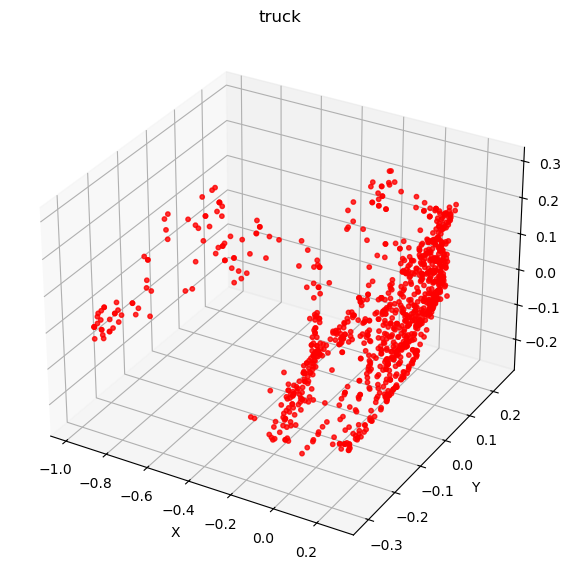

Class: truck


In [23]:
def plot_pc(points, title):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o', s=10, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
# visualize 5 samples
for i in range(5):
    idx = np.random.randint(0, len(train_dataset))
    sample = train_dataset[idx]
    points = sample['points']
    label = sample['label'].item()
    class_name = reverse_labels[label]
    
    plot_pc(points, class_name)
    print(f"Class: {class_name}")
    